In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
### SUBSPECIES LEVEL ###
random_effect_subspecies = pd.read_csv("effect_size/output/random_effects_subsp.tsv",sep='\t').rename(columns={'species':'subspecies'})
random_effect_subspecies.subspecies = random_effect_subspecies.subspecies.astype(str).str.rjust(10,'0')
random_effect_subspecies = random_effect_subspecies.set_index('subspecies')

random_effect_subspecies['cluster95'] = random_effect_subspecies.index.str[:4]


### SPECIES LEVEL ###
random_effect_species = pd.read_csv("effect_size/output/random_effects_sp.tsv",sep='\t')
random_effect_species.species = random_effect_species.species.astype(str).str.rjust(4,'0')
random_effect_species = random_effect_species.set_index('species')


In [4]:
per_study_effect_subspecies = pd.read_csv("effect_size/output/per_study_subsp.tsv",sep='\t').rename(columns={'species':'subspecies'})
per_study_effect_subspecies.subspecies = per_study_effect_subspecies.subspecies.astype(str).str.rjust(10,'0')
per_study_effect_subspecies = per_study_effect_subspecies.set_index('subspecies')

per_study_effect_subspecies['cluster95'] = per_study_effect_subspecies.index.str[:4]

### SPECIES LEVEL ###
per_study_effect_species = pd.read_csv("effect_size/output/per_study_sp.tsv",sep='\t')
per_study_effect_species.species = per_study_effect_species.species.astype(str).str.rjust(4,'0')
per_study_effect_species = per_study_effect_species.set_index('species')


In [6]:
subsp_def = pd.read_csv("../benchmark/fullname_subsp_def_sourmash.txt",sep='\t')
subsp_def['subspecies'] = subsp_def['subspecies'].astype(str).str.rjust(10,'0')
subsp_def['cluster95'] = subsp_def['subspecies'].str[:4]

In [7]:
Tax = pd.read_csv("effect_size/tax.tsv",sep='\t',index_col=0)
Tax.cluster95 = Tax.cluster95.astype(str).str.rjust(4,'0')
Tax.index = Tax.index.astype(str).str.rjust(10,'0')
Tax.subspecies = Tax.subspecies.astype(str).str.rjust(6,'0')
Tax.Label = Tax.Label.str.lstrip("s__")

species_tax = Tax[['cluster95','species']]
species_tax.columns = ['cluster95','Label']
species_tax = species_tax.set_index('cluster95')

Tax = pd.concat([Tax,species_tax]).Label

Tax = Tax.loc[~Tax.duplicated()]
Tax = Tax.str.replace(" ", "\n")

Tax = pd.concat([Tax,pd.Series({'4194001001':'Porphyromonas\nsp900548415\n001001'})])
Tax = pd.concat([Tax,pd.Series({'0333':'Agathobacter'})])
Tax = pd.concat([Tax,pd.Series({'0055':'Faecalibacterium'})])
Tax = pd.concat([Tax,pd.Series({'0055001001':'Faecalibacterium\n001001'})])
Tax = pd.concat([Tax,pd.Series({'2501':'UMGS363'})])
Tax = pd.concat([Tax,pd.Series({'1129':'Pseudoflavonifractor'})])

In [39]:
def forest_plot(species):
    species_df = pd.DataFrame(random_effect_species.loc[species]).T

    plotting_df = pd.concat([species_df,random_effect_subspecies.query("cluster95 == @species")])
    plotting_df['Taxonomy_level'] = plotting_df.index.map(lambda x: 'speices' if len(x) == 4 else 'subspecies')

    df_sorted = plotting_df.sort_values(by=['Taxonomy_level', 'mean_effect_size'])

    df_sorted = df_sorted.merge(per_study_effect_species.loc[species][['study','effect_size']],left_index=True,right_index=True,how='outer')
    df_sorted = df_sorted.merge(per_study_effect_subspecies.query("cluster95 == @species")[['study','effect_size']],left_index=True,right_index=True,how='outer')

    df_sorted['effect_size'] = df_sorted['effect_size_x'].fillna(0) + df_sorted['effect_size_y'].fillna(0)
    df_sorted['study'] = df_sorted['study_x'].fillna('') + df_sorted['study_y'].fillna('')
    df_sorted = df_sorted.drop(['effect_size_x','effect_size_y','study_x','study_y'],axis=1)

    df_sorted.index = df_sorted.index.map(Tax)
    
    unique_studies = df_sorted['study'].unique()
    palette = sns.color_palette("deep", len(unique_studies))
    study_color_map_seaborn = {study: color for study, color in zip(unique_studies, palette)}

    # Generate a color map
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_studies)))

    # Map each study to a color
    study_color_map = {study: color for study, color in zip(unique_studies, colors)}
    
    # Start the plot
    fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the effect sizes
    ax.errorbar(df_sorted['mean_effect_size'], df_sorted.index, xerr=[df_sorted['mean_effect_size'] - df_sorted['ci_lower'], df_sorted['ci_upper'] - df_sorted['mean_effect_size']],
                fmt='D', color='black', ecolor='black', elinewidth=0, capsize=0,ms=10)


    for _, row in df_sorted.iterrows():
        ax.scatter(row['effect_size'], row.name, color=study_color_map_seaborn[row['study']], alpha=1,s=50)

    # Draw a line at effect size = 0 for reference
    #ax.axvline(x=0, color='black', linestyle='-',linewidth=2)
    ax.axvline(x=0.2, color='red', linestyle='--',linewidth=2)
    # Set the y-axis to show the taxonomy labels
    ax.set_yticks(df_sorted.index)
    plt.yticks(fontsize=13,style='italic')
    plt.xticks(fontsize=13)

    # Set the x-axis label
    ax.set_xlabel('',fontsize=0)

    # Invert y-axis so the species are on top
    ax.invert_yaxis()

    # Get current y-axis limits
    current_ylim = ax.get_ylim()

    # Calculate new limits, adding one category at both ends
    new_ylim = (current_ylim[0] + 0.22, current_ylim[1] - 0.22)

    # Set new y-axis limits
    ax.set_ylim(new_ylim)


    study_labels_seaborn = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in palette]

    # Show the grid
    ax.grid(True,linewidth=0.5)
    # Show the plot
    plt.tight_layout()
    plt.show()

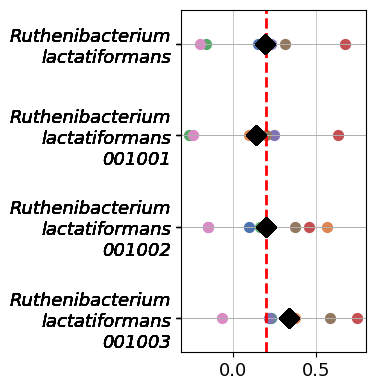

In [9]:
forest_plot('0174')

In [10]:
sig_subsp = random_effect_subspecies.loc[(random_effect_subspecies['p_value_adj'] < 0.1) & (abs(random_effect_subspecies['mean_effect_size']) > 0.2)]
sig_sp = random_effect_species.loc[(random_effect_species['p_value_adj'] < 0.1) & (abs(random_effect_species['mean_effect_size']) > 0.2)]

In [11]:
# Corresponding species is not significant
not_species = sig_subsp.loc[~sig_subsp.cluster95.isin(sig_sp.index)].index

In [12]:
# At least one subsp is significant, the other one is not

filtered_subspecies = random_effect_subspecies.groupby('cluster95').filter(lambda x: len(x) >= 2)
def check_conditions(group):
    condition_met = group.apply(lambda x: abs(x['mean_effect_size']) > 0.2 and x['p_value_adj'] < 0.1, axis=1)
    return condition_met.any() and not all(condition_met)

sig_subsp_regardless_of_sp = filtered_subspecies.groupby('cluster95').filter(check_conditions).index

In [13]:
random_effect_subspecies['log_p_value_adj'] = -np.log(random_effect_subspecies['p_value_adj'])

In [14]:
mask=random_effect_subspecies.index.isin(not_species)
colors = np.where(mask, 'red', 'black')

In [15]:
df_black = random_effect_subspecies[~mask]  # Points that are not highlighted
df_red = random_effect_subspecies[mask]

In [16]:
mask=random_effect_subspecies.index.isin(sig_subsp_regardless_of_sp)
colors = np.where(mask, 'blue', 'green')

df_green = random_effect_subspecies[~mask]  # Points that are not highlighted
df_blue = random_effect_subspecies[mask]

In [17]:
df_blue = df_blue.loc[(df_blue['p_value_adj'] < 0.1) & (abs(df_blue['mean_effect_size']) > 0.2)]

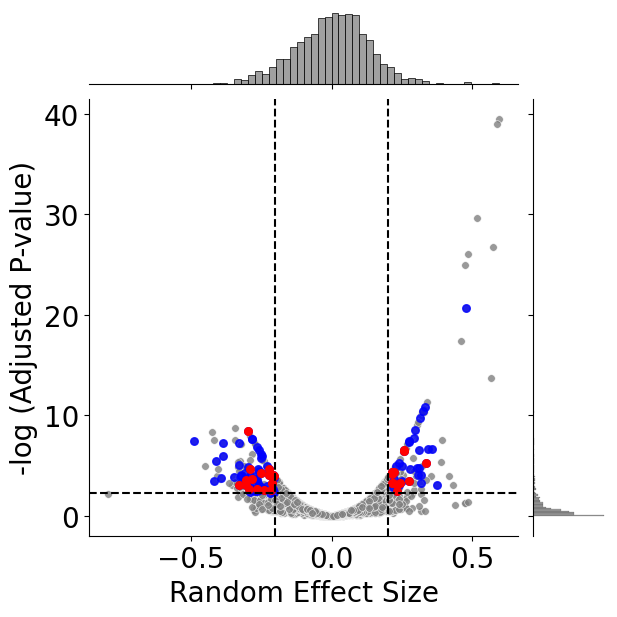

In [18]:
joint_plot = sns.jointplot(data=df_black,x='mean_effect_size',y='log_p_value_adj',color='gray',s=30,alpha=0.8)
joint_plot.ax_joint.scatter(df_blue['mean_effect_size'], df_blue['log_p_value_adj'], color='blue',s=30,alpha=0.8)
joint_plot.ax_joint.scatter(df_red['mean_effect_size'], df_red['log_p_value_adj'], color='red',s=30,alpha=1)
joint_plot.set_axis_labels('Random Effect Size', '-log (Adjusted P-value)',fontsize=20)
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=20)  # Adjust the labelsize as needed

joint_plot.ax_joint.axvline(-0.2, color='black', linestyle='--')
joint_plot.ax_joint.axvline(0.2, color='black', linestyle='--')
joint_plot.ax_joint.axhline(-np.log(0.1), color='black', linestyle='--')

#plt.ylim(0,15)
#plt.savefig("/Users/trickovi/switchdrive/presentations/figures/AI/figure 3/volcano_plot.svg")
plt.show()

In [19]:
plotting_df = per_study_effect_subspecies.merge(random_effect_subspecies,left_index=True,right_index=True).drop("cluster95_y",axis=1).rename(columns = {"cluster95_x":"cluster95"})

In [20]:
#combined = list(set(df_red.index).union(set(df_blue.index)))
combined = list(set(df_red.index))

In [21]:
plotting_df_filtered = plotting_df.loc[plotting_df.index.isin(combined)]

In [22]:
plotting_df_filtered = plotting_df_filtered.sort_values('mean_effect_size',ascending=True)

In [23]:
to_plot = list(set(plotting_df_filtered.index.unique()[-10:]).union(set(plotting_df_filtered.index.unique()[:10])))

In [24]:
plotting_df_filtered = plotting_df_filtered.loc[plotting_df_filtered.index.isin(to_plot)]

In [25]:
plotting_df_filtered.index = plotting_df_filtered.index.map(Tax)

In [26]:
plotting_df_filtered.index = plotting_df_filtered.index.str.replace("\n"," ")

In [27]:
plotting_df_filtered = plotting_df_filtered.dropna()

In [44]:
palette = sns.color_palette("deep", len(per_study_effect_subspecies.study.unique()))
study_color_map_seaborn = {study: color for study, color in zip(per_study_effect_subspecies.study.unique(), palette)}

In [48]:
plotting_df_filtered.index= plotting_df_filtered.index.astype(str)

/var/folders/72/nfvm3kz10tvfvkbqk8st2m48w_nvfh/T/ipykernel_9403/4052922580.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


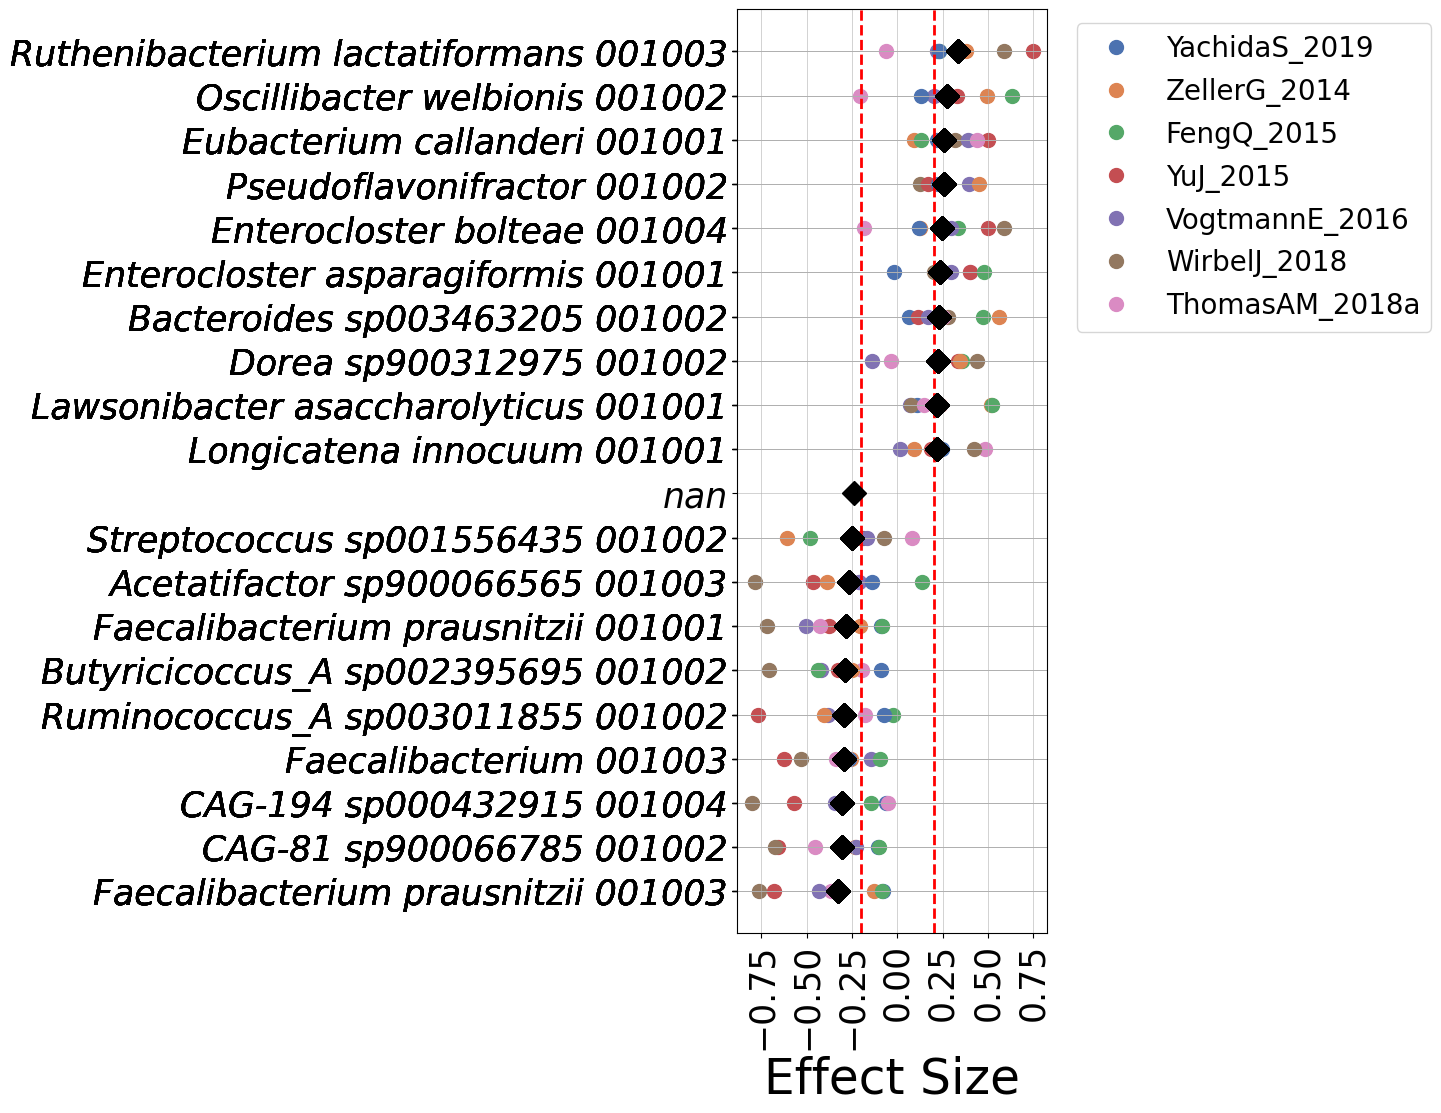

In [50]:
# Start the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Plot the effect sizes
ax.errorbar(plotting_df_filtered['mean_effect_size'], plotting_df_filtered.index, xerr=[plotting_df_filtered['mean_effect_size'] - plotting_df_filtered['ci_lower'], plotting_df_filtered['ci_upper'] - plotting_df_filtered['mean_effect_size']],
            fmt='D', color='black', ecolor='black', elinewidth=0, capsize=0,ms=12)

for _, row in plotting_df_filtered.iterrows():
    ax.scatter(row['effect_size'], row.name, color=study_color_map_seaborn[row['study']], alpha=1,s=100)


# Draw a line at effect size = 0 for reference
#ax.axvline(x=0, color='black', linestyle='-',linewidth=2)
ax.axvline(x=0.2, color='red', linestyle='--',linewidth=2)
ax.axvline(x=-0.2, color='red', linestyle='--',linewidth=2)

# Set the y-axis to show the taxonomy labels
ax.set_yticks(plotting_df_filtered.index)
plt.yticks(fontsize=25,style='italic')
plt.xticks(fontsize=25,rotation=90)
#ax.set_yticklabels(df_sorted['Taxonomy'])

# # Set the x-axis label
ax.set_xlabel('Effect Size',fontsize=35)

# # Invert y-axis so the species are on top
#ax.invert_yaxis()


# Existing code for generating study_labels_seaborn
study_labels_seaborn = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in palette]
study_labels = per_study_effect_subspecies.study.unique()

# Create a separate handle and label for 'Random effect'
random_effect_legend = plt.Line2D([0], [0], color='black', marker='o', linestyle='', markersize=10)
random_effect_label = ['Random effect']

# Combine the two sets of handles and labels
all_handles = study_labels_seaborn + [random_effect_legend]
list(study_labels).append('Random effect')

# Create a single legend with both sets
ax.legend(all_handles, study_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)


# study_labels_seaborn = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10) for color in palette]
# ax.legend(study_labels_seaborn, unique_studies, bbox_to_anchor=(1.05, 1), loc='upper left', title="",fontsize=20)

# # Show the grid
ax.grid(True,linewidth=0.4)

# # Show the plot
plt.tight_layout()

#plt.savefig("/Users/trickovi/switchdrive/presentations/figures/AI/figure 3/blue_ones.svg",bbox_inches='tight')

plt.show()